In [49]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [50]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [51]:
#Create variables for the stock we are analyzing and the amount of time

ticker = "ETH-USD"
inter = "5m" #crypto has to be every 5 minutes while stocks is 1m

In [52]:
df = pd.read_csv(
    Path(f"{ticker}_prices_{inter}_January.csv"),
    parse_dates=True,
    infer_datetime_format=True)

In [53]:
df = df.set_index(pd.DatetimeIndex(df['Datetime']), drop=True, append=False, inplace=False, verify_integrity=False)

In [137]:
df.tail()

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-01-26 00:45:00+00:00,2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,2437.05,1313792
2022-01-26 00:50:00+00:00,2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,2432.26,15685632
2022-01-26 00:55:00+00:00,2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,2427.48,6836224
2022-01-26 01:00:00+00:00,2022-01-26 01:00:00+00:00,2427.53,2427.53,2427.53,2427.53,2427.53,0
2022-01-26 01:01:00+00:00,2022-01-26 01:01:00+00:00,2427.45,2427.45,2427.45,2427.45,2427.45,0


In [55]:
#This function accepts the column number for the features (X) and the target (y). It chunks the data up with a rolling window of Xt - window to predict Xt. It returns two numpy arrays of X and y.

def window_data(df, window, feature_col_number, target_col_number):

    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [56]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 25

feature_column = 4
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:2]} \n")
print (f"y sample values:\n{y[:2]}")

X sample values:
[[3536.39 3538.47 3538.91 3546.87 3531.4  3534.06 3540.78 3546.69 3542.01
  3540.03 3544.24 3546.51 3540.55 3535.53 3532.08 3540.63 3539.88 3535.56
  3528.   3529.55 3530.38 3529.38 3522.68 3525.25 3523.72]
 [3538.47 3538.91 3546.87 3531.4  3534.06 3540.78 3546.69 3542.01 3540.03
  3544.24 3546.51 3540.55 3535.53 3532.08 3540.63 3539.88 3535.56 3528.
  3529.55 3530.38 3529.38 3522.68 3525.25 3523.72 3530.46]] 

y sample values:
[[3530.46]
 [3520.64]]


In [57]:
X.shape

(5675, 25)

In [58]:
y.shape

(5675, 1)

In [59]:
# Use 70% of the data for training and the remainder for testing
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [60]:
X_train.shape

(4540, 25)

In [61]:
y_train.shape

(4540, 1)

In [62]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [63]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [64]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [65]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 25
dropout_fraction = 0.3

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [66]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [67]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 25, 25)            2700      
                                                                 
 dropout_3 (Dropout)         (None, 25, 25)            0         
                                                                 
 lstm_4 (LSTM)               (None, 25, 25)            5100      
                                                                 
 dropout_4 (Dropout)         (None, 25, 25)            0         
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [135]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=96)

Epoch 1/100
48/48 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 2/100
48/48 [==============================] - 1s 22ms/step - loss: 0.0019
Epoch 3/100
48/48 [==============================] - 1s 23ms/step - loss: 0.0041
Epoch 4/100
48/48 [==============================] - 1s 22ms/step - loss: 0.0022: 0s - loss: 0.0
Epoch 5/100
48/48 [==============================] - 1s 22ms/step - loss: 0.0023
Epoch 6/100
48/48 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 7/100
48/48 [==============================] - 1s 21ms/step - loss: 0.0040
Epoch 8/100
48/48 [==============================] - 1s 22ms/step - loss: 6.5573e-04
Epoch 9/100
48/48 [==============================] - 1s 25ms/step - loss: 7.3836e-04
Epoch 10/100
48/48 [==============================] - 1s 23ms/step - loss: 6.8181e-04
Epoch 11/100
48/48 [==============================] - 1s 25ms/step - loss: 6.1681e-04
Epoch 12/100
48/48 [==============================] - 1s 31ms/step - loss: 

In [138]:
# Make some predictions
predicted = model.predict(X_test)
predicted.shape

(1135, 1)

In [139]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [140]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Datetime,,
2022-01-22 00:25:00+00:00,2356.431134,2345.500977
2022-01-22 00:30:00+00:00,2364.097183,2346.339111
2022-01-22 00:35:00+00:00,2367.545122,2348.428467
2022-01-22 00:40:00+00:00,2366.382735,2351.297363
2022-01-22 00:45:00+00:00,2366.978191,2353.619629


In [141]:
conditions = [
    (stocks['Real'] > stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] < stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] == stocks['Predicted'].shift(periods=-1))
     ]

values = ['-1', '1', '0']

stocks['Signal'] = np.select(conditions, values)

In [142]:
stocks.tail(7)

,Real,Predicted,Signal
Datetime,,,
2022-01-26 00:35:00+00:00,2309.814426,2309.416992,-1
2022-01-26 00:40:00+00:00,2309.040689,2309.714844,1
2022-01-26 00:45:00+00:00,2304.833277,2310.136475,1
2022-01-26 00:50:00+00:00,2303.125352,2310.272705,1
2022-01-26 00:55:00+00:00,2301.420993,2309.882324,1
2022-01-26 01:00:00+00:00,2301.438821,2309.299072,1
2022-01-26 01:01:00+00:00,2301.410297,2308.754150,0


In [176]:
import tensorflow as tf
from tensorflow import keras

In [180]:
mseObject = keras.losses.MeanSquaredError()
mseTensor = mseObject(stocks['Real'], stocks['Predicted'])
mse = mseTensor.numpy()

print(mse)

296.93927


<AxesSubplot:xlabel='Datetime'>

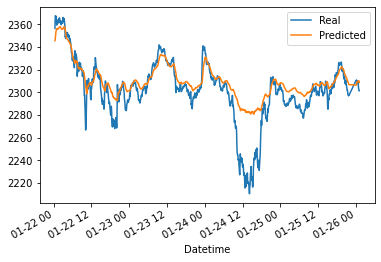

In [143]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

In [144]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 0s 6ms/step - loss: 0.0022


0.002222033217549324

In [145]:
new_df = pd.read_csv(
    Path(f"{ticker}_prices_{inter}NEWDATA.csv"),
    parse_dates=True,
    infer_datetime_format=True)

In [146]:
new_df = new_df.set_index(pd.DatetimeIndex(new_df['Datetime']), drop=True, append=False, inplace=False, verify_integrity=False)

In [147]:
new_df.tail()

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-01-27 23:05:00+00:00,2022-01-27 23:05:00+00:00,2391.88,2398.28,2391.88,2398.28,2398.28,85396480
2022-01-27 23:10:00+00:00,2022-01-27 23:10:00+00:00,2405.00,2406.48,2404.70,2404.70,2404.70,49141760
2022-01-27 23:15:00+00:00,2022-01-27 23:15:00+00:00,2408.09,2412.15,2407.57,2407.57,2407.57,81558528
2022-01-27 23:20:00+00:00,2022-01-27 23:20:00+00:00,2405.66,2405.66,2405.66,2405.66,2405.66,7197696
2022-01-27 23:21:00+00:00,2022-01-27 23:21:00+00:00,2405.63,2405.63,2405.63,2405.63,2405.63,0


In [148]:
new_df.shape

(510, 7)

In [150]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 25

feature_column = 4
target_column = 4
X_new, y_new = window_data(new_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X_new[:2]} \n")
print (f"y sample values:\n{y_new[:2]}")

X sample values:
[[2496.69 2490.3  2487.04 2486.21 2487.7  2486.63 2486.01 2485.92 2488.95
  2492.66 2486.71 2480.19 2480.11 2479.03 2479.02 2482.92 2481.09 2475.5
  2467.01 2462.53 2461.94 2455.84 2453.94 2453.34 2451.24]
 [2490.3  2487.04 2486.21 2487.7  2486.63 2486.01 2485.92 2488.95 2492.66
  2486.71 2480.19 2480.11 2479.03 2479.02 2482.92 2481.09 2475.5  2467.01
  2462.53 2461.94 2455.84 2453.94 2453.34 2451.24 2449.87]] 

y sample values:
[[2449.87]
 [2450.3 ]]


In [151]:
X_new

array([[2496.69, 2490.3 , 2487.04, ..., 2453.94, 2453.34, 2451.24],
       [2490.3 , 2487.04, 2486.21, ..., 2453.34, 2451.24, 2449.87],
       [2487.04, 2486.21, 2487.7 , ..., 2451.24, 2449.87, 2450.3 ],
       ...,
       [2334.52, 2329.14, 2331.66, ..., 2390.56, 2398.28, 2404.7 ],
       [2329.14, 2331.66, 2335.21, ..., 2398.28, 2404.7 , 2407.57],
       [2331.66, 2335.21, 2334.9 , ..., 2404.7 , 2407.57, 2405.66]])

In [152]:
y_new.shape

(485, 1)

In [153]:
# Use 70% of the data for training and the remainder for testing
X_new_test = X_new.copy()
y_new_test = y_new.copy()

In [154]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the new feature data
scaler.fit(X_new)
X_new_test = scaler.transform(X_new)

# Fit the MinMaxScaler object with the new target data <- VERY IMPORTANT
scaler.fit(y_new)
y_new_test = scaler.transform(y_new_test)


In [155]:
# Make some predictions
predicted_values_new = model.predict(X_new_test)
predicted_values_new.shape

(485, 1)

In [156]:
# this uses the scaler that was fit on the y_new data (which is shaped similarly as the predictions)
predicted_prices = scaler.inverse_transform(predicted_values_new)

In [157]:
predicted_df = new_df.iloc[25:510,].copy()
predicted_df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-01-26 07:05:00+00:00,2022-01-26 07:05:00+00:00,2450.69,2450.84,2449.65,2449.87,2449.87,0
2022-01-26 07:10:00+00:00,2022-01-26 07:10:00+00:00,2450.15,2451.17,2450.15,2450.30,2450.30,120448000
2022-01-26 07:15:00+00:00,2022-01-26 07:15:00+00:00,2450.34,2451.55,2449.55,2451.55,2451.55,0
2022-01-26 07:20:00+00:00,2022-01-26 07:20:00+00:00,2452.55,2455.91,2452.55,2455.91,2455.91,42348544
2022-01-26 07:25:00+00:00,2022-01-26 07:25:00+00:00,2455.94,2455.94,2453.88,2454.14,2454.14,0


In [158]:
len(predicted_df)

485

In [159]:
predicted_df_final = pd.DataFrame(index=predicted_df.index)

In [160]:
predicted_df_final["Actual_close"]= new_df["Close"]
predicted_df_final["Predicted_close"]= predicted_prices

<AxesSubplot:xlabel='Datetime'>

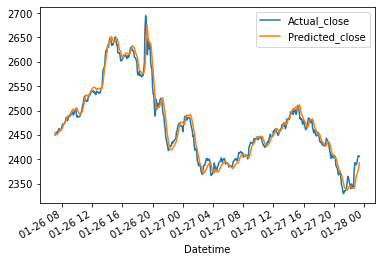

In [161]:
predicted_df_final.plot()

In [162]:
predicted_df_final.tail()

,Actual_close,Predicted_close
Datetime,,
2022-01-27 23:05:00+00:00,2398.28,2370.945312
2022-01-27 23:10:00+00:00,2404.70,2375.122803
2022-01-27 23:15:00+00:00,2407.57,2381.019287
2022-01-27 23:20:00+00:00,2405.66,2387.413086
2022-01-27 23:21:00+00:00,2405.63,2392.341797


In [163]:
model.evaluate(X_new_test, y_new_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.0015


0.0014654876431450248